<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/bMCML/kimetal_tenx_bmcml_l1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

bMCML analysis with L1 norm

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2065','.gz')

#tenx.mtx (log counts)
download_file('10.22002/D1.2072','.gz')

#var.csv
download_file('10.22002/D1.2066','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2065 metadata.csv")
os.system("mv D1.2072 tenx.mtx")
os.system("mv D1.2066 var.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/940 [00:00<?, ?B/s]

  0%|          | 0/104912 [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 2.50 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 703 (delta 154), reused 246 (delta 136), pack-reused 424
Receiving objects: 100% (703/703), 258.23 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (367/367), done.
Checking out files: 100% (81/81), done.


In [ ]:
%cd /content/CP_2023/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy

     |████████████████████████████████| 96 kB 2.7 MB/s 
     |████████████████████████████████| 7.7 MB 1.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 64.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## **Install Packages**

In [ ]:
import anndata
import pandas as pd
import numpy as np
from MCML import MCML, bMCML #Now has continuous label addition
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')


## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

pcs = 50
n_latent = 50

In [ ]:
genes = pd.read_csv(data_path+'/var.csv')

In [ ]:
count_mat = sio.mmread(data_path+'/tenx.mtx')
count_mat.shape

(41580, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,cell_barcode,cluster_color,cluster,cluster_id,cell_types,sex_label,batch_indices,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
0,10x_VMH_Female_Control_1,4_AAACCTGAGCGCCTCA,#9162FF,Nr5a1_4,24.0,undefined,F,0,1427.0,926,13.594954,True,False
1,10x_VMH_Female_Control_1,4_AAACCTGCACAGTCGC,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,4508.0,2310,9.272405,True,False
2,10x_VMH_Female_Control_1,4_AAACCTGCAGATTGCT,#66ABC2,Dlk1_3,16.0,undefined,F,0,3447.0,1995,5.483029,True,False
3,10x_VMH_Female_Control_1,4_AAACCTGCATACTCTT,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,7004.0,3286,4.483152,True,True
4,10x_VMH_Female_Control_1,4_AAACCTGGTCCGTTAA,#24EFCD,Scgn,20.0,undefined,F,0,2490.0,1492,9.277108,True,False


In [ ]:
meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1]

3.829829248460913

In [ ]:
meta.cluster.value_counts()

Nr5a1_4          3827
Dlk1_3           2317
Satb2_2          2132
Dlk1_4           2124
Dlk1_1           2046
Dlk1_2           1830
Nr5a1_1          1794
Tsix_Esr1_1      1659
Nr5a1_Foxp2_2    1571
Satb2_1          1567
Nr5a1_Foxp2_1    1500
Dlk1_5           1487
Esr1_2           1390
Esr1_1           1310
Dlk1_6           1304
Nr5a1_3          1223
Esr1_5           1210
Nup62cl          1201
Esr1_4           1070
Esr1_3           1059
Nr5a1_7          1050
Nr5a1_10         1041
Nr5a1_9          1018
Nr5a1_2          1003
Nr5a1_5          1002
Nr5a1_8           838
Satb2_3           798
Scgn              514
Esr1_6            500
Nr5a1_6           195
Name: cluster, dtype: int64

In [ ]:
lab1 = list(meta.cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.sample_name)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))
shuff_lab2 = random.sample(lab2, len(lab2))
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.cluster_color))

sex_colors = ['#F8C471','#abacb7']

Calculate metrics on ambient data, for reference

In [ ]:
amb = tl.getCentroidDists(count_mat,meta.cluster,m='l1')
ambIntra = tl.getIntraVar(count_mat, meta.cluster, meta.sex_label,m='l1')
ambIntraC = tl.getIntraVar(count_mat, meta.cluster, meta.cluster,m='l1')
ambInter = tl.getInterVar(count_mat, meta.cluster, meta.sex_label,m='l1')


In [ ]:
def getAllVars(latents,latentLab,latentType):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, meta.cluster,m='l1')
    intra = tl.getIntraVar(i, meta.cluster, meta.sex_label,m='l1')
    intraC = tl.getIntraVar(i, meta.cluster, meta.cluster,m='l1')
    inter = tl.getInterVar(i, meta.cluster, meta.sex_label,m='l1')

    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0], stats.pearsonr(intraC, ambIntraC)[0], stats.pearsonr(inter, ambInter)[0]]
    dist += ['Inter-Type','Intra-Sex','Intra-Type','Inter-Sex']

    emb += [l]*4
    dim += [d]*4


  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim


  return allVals


In [ ]:
# reducer = umap.UMAP(n_components = ndims, random_state = state)
# tsne = TSNE(n_components = ndims, random_state = state)

###**Biased Reconstruction MCML**

Optimizing for correlation of user-specified intra-(or inter-)label metrics

In [ ]:
rounds = 3

In [ ]:
#Optimize for intra-sex correlation
gen = []
genLab = []
genType = []


for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 100,batch_size = 400) #400
  lossesGen, latentGen = nca.fit(count_mat,allLabs[0],allLabs[1], silent=True,ret_loss=True,p=1.0)

  gen += [latentGen]
  genLab += ['Intra-Sex MCML']
  genType += ['MCML 50D']



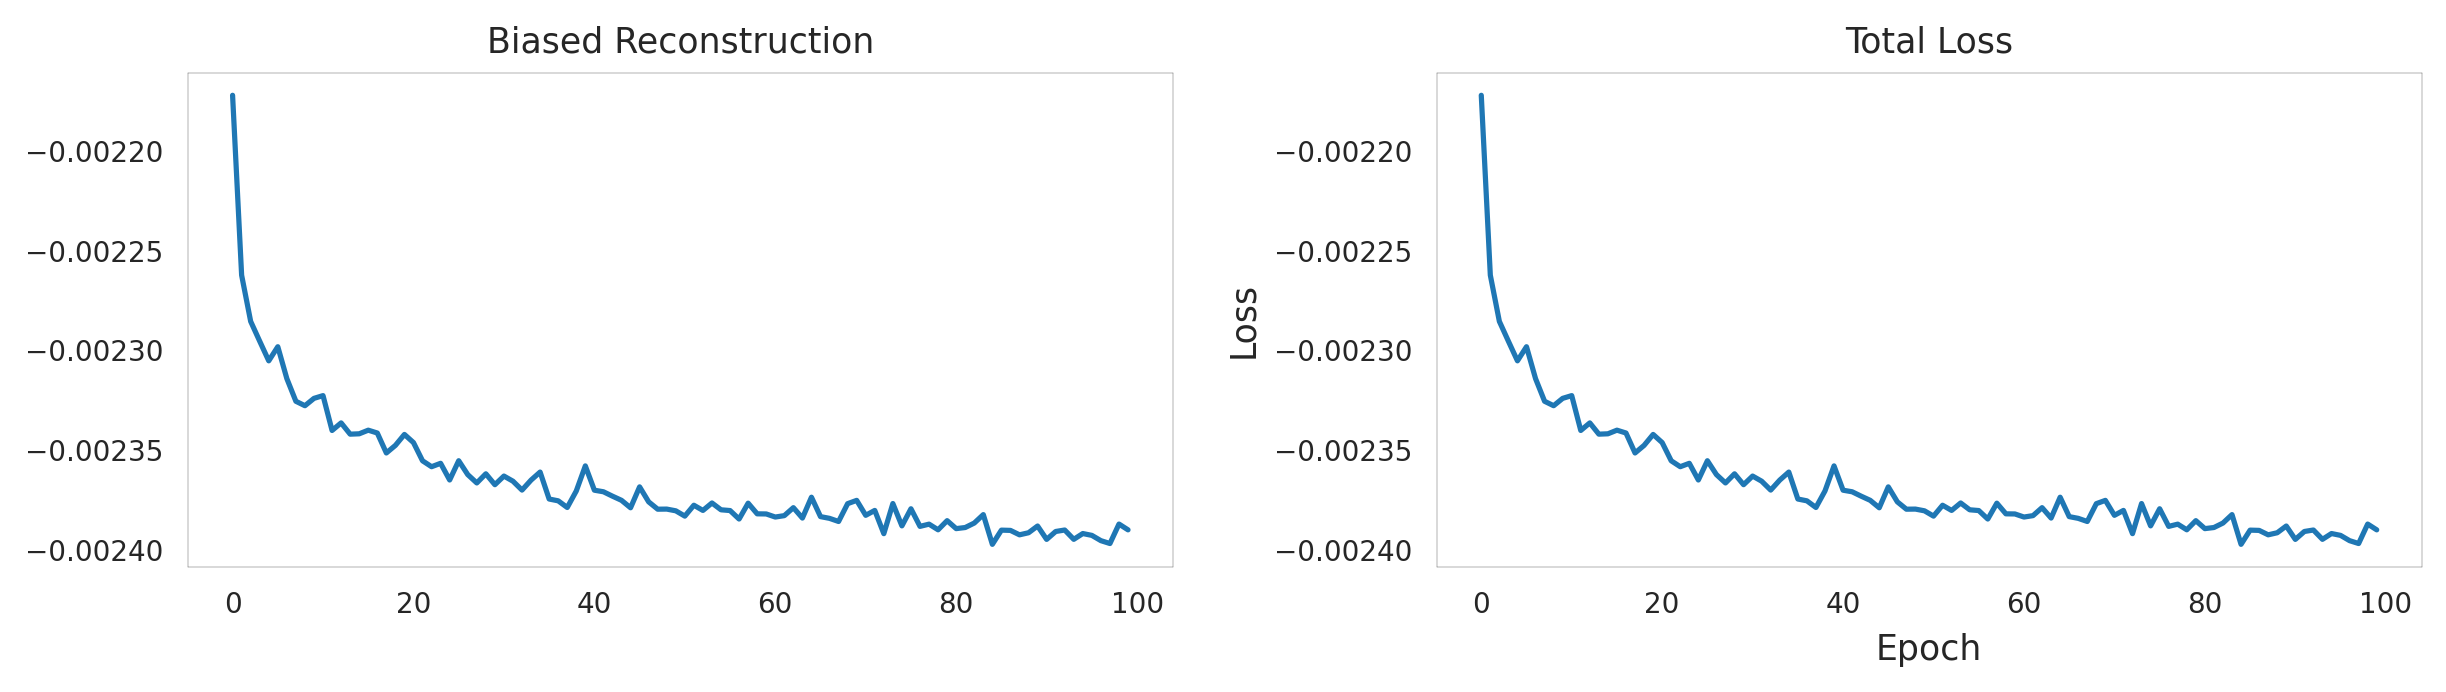

In [ ]:
#Sex loss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

In [ ]:
#Optimize for intra-type correlation (cell type)
typ = []
typLab = []
typType = []

for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 100, batch_size = 400)
  lossesType, latentType = nca.fit(count_mat,allLabs[0],allLabs[0], silent=True,ret_loss=True,p=1.0)

  typ += [latentType]
  typLab += ['Intra-Type MCML']
  typType += ['MCML 50D']



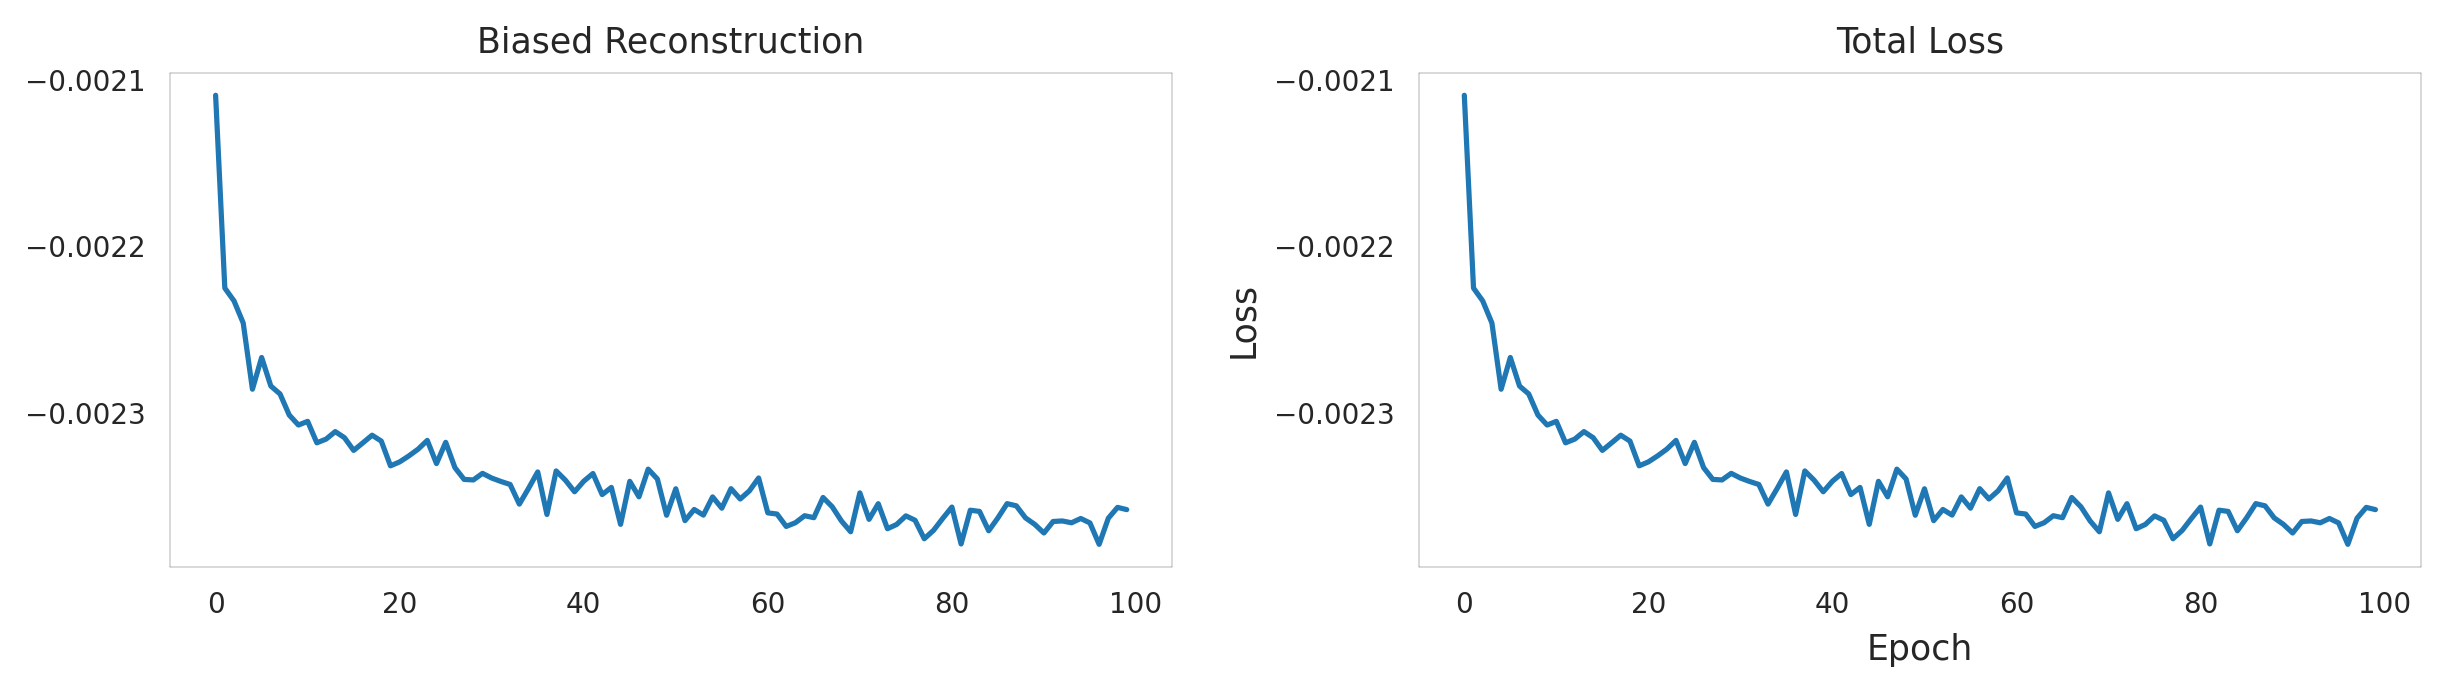

In [ ]:
#Type loss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Get latent spaces for comparison (baselines)

In [ ]:
def reconComp(scaled_mat, ndims=2, pcs=50, rounds = 3):
	""" Compute latent space representations as baseline for reconstruction abilities
	scaled_mat : Numpy array of latent space (n_obs x n_latent)
	ndims : No. of dimensions to reduce scaled_mat to
	pcs : No. of PCs to use
	rounds : No. of rounds to replicate over
	Returns:
	latents : List containing each generated latent space
	latentLab : List containing label for each latent space
	latentType : List containing broad category label for each latent space
	"""

	latents = []
	latentLab = []
	latentType = []

	nanLabs = np.array([[np.nan]*scaled_mat.shape[0]])

	for i in range(rounds):
		tsvd = TruncatedSVD(n_components=pcs)
		x_pca = tsvd.fit_transform(scaled_mat)

		tsvd = TruncatedSVD(n_components=2)
		x_pca_2d = tsvd.fit_transform(scaled_mat)

		# tsne = TSNE(n_components = pcs,method='exact') #-->t-SNE taskes very long time
		# pcaTSNE = tsne.fit_transform(scaled_mat)

		reducer = umap.UMAP(n_components = pcs)
		pcaUMAP = reducer.fit_transform(count_mat)


		densUMAP = umap.UMAP(n_components = pcs,densmap=True)
		pcaDensUMAP = densUMAP.fit_transform(count_mat)

		# pcaDensTSNE, ro ,re = densne.run_densne(scaled_mat,no_dims = pcs)


		#MCML runs
		ncaR = MCML(n_latent = pcs, epochs = 100)

		lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)

		latents += [latentR, x_pca, x_pca_2d, pcaDensUMAP,pcaUMAP ]
		latentLab += ['Recon MCML 50D','PCA 50D','PCA 2D','densMap 50D','UMAP 50D']
		latentType += ['50D','50D','2D','50D','50D']

	return latents,latentLab,latentType

In [ ]:
latents,latentLab,latentType = reconComp(scaled_mat, ndims=2, pcs=50)

See correlation of intra- and inter- metrics for dataset optimized for **intra-sex**

In [ ]:
latents = gen + latents

latentLab = genLab + latentLab

latentType = genType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
#allVals = allVals[~allVals['Latent'].isin(['PCA 2D'])]

In [ ]:

#allVals = allVals[~allVals['Latent'].isin(['Intra-Sex MCML'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
intraSex = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Sex MCML']) & allVals['Distance'].isin(['Intra-Sex'])])

print((intraSex-pca)/pca)
print((intraSex-recon)/recon)

0.3386239987153125
0.298301496640752


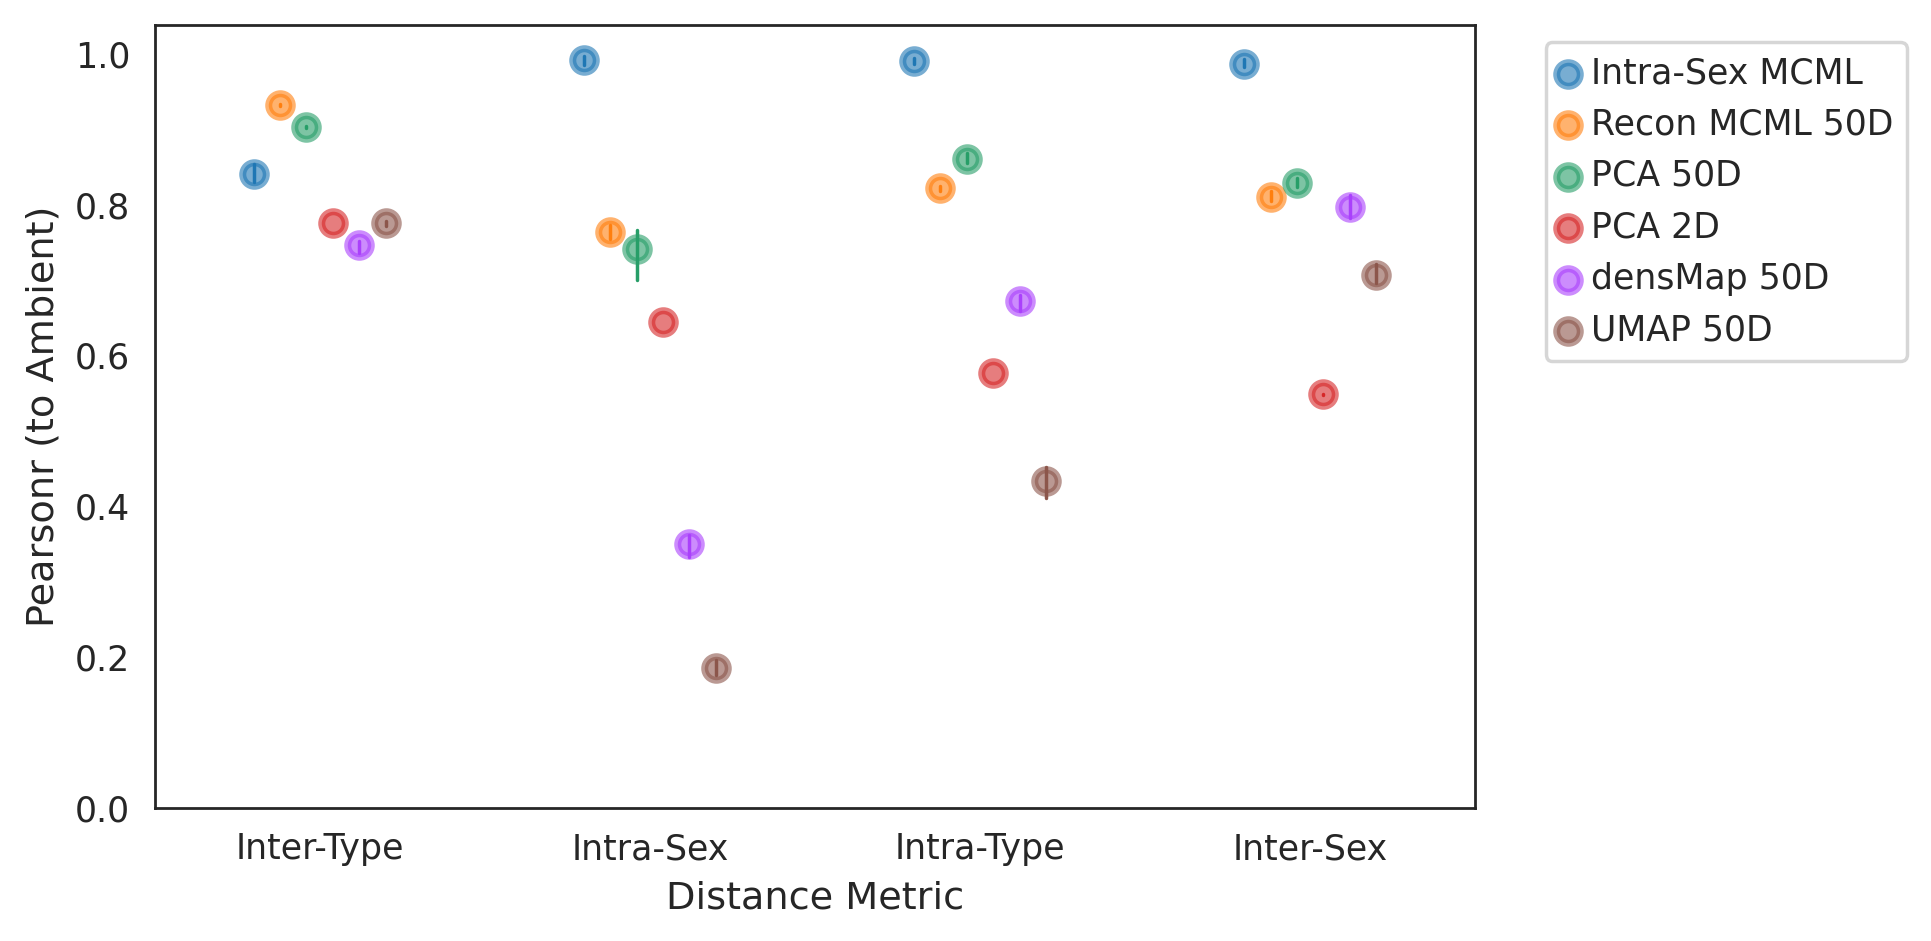

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None,ymin=0)

In [ ]:

from google.colab import files

allVals.to_csv('intraSex10x.csv')
files.download('intraSex10x.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

See correlation of intra- and inter- metrics for dataset optimized for **intra-type**

In [ ]:
latents = typ + latents

latentLab = typLab + latentLab

latentType = typType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Intra-Sex MCML'])]

In [ ]:
#allVals = allVals[~allVals['Latent'].isin(['Intra-Sex MCML','PCA 2D'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Type'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Type'])])
intraType = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Type MCML']) & allVals['Distance'].isin(['Intra-Type'])])

print((intraType-pca)/pca)
print((intraType-recon)/recon)

0.12077426184914507
0.20206293246501122


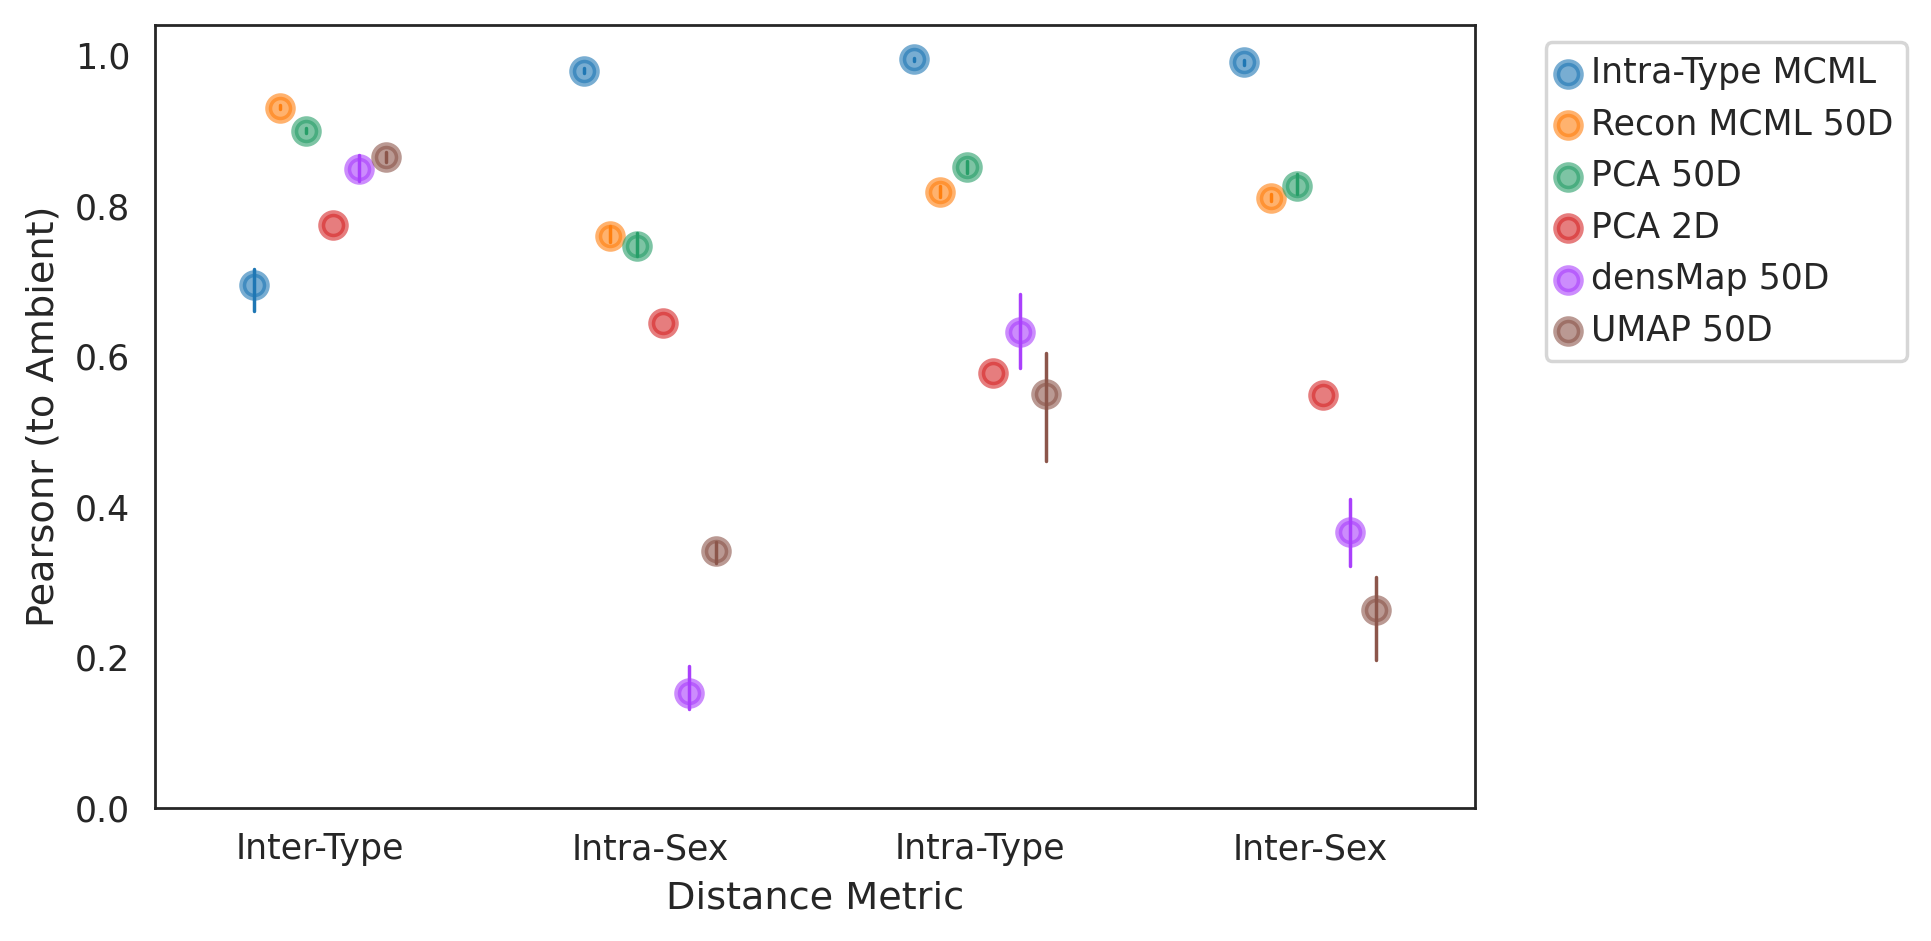

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None,ymin= 0)

In [ ]:

from google.colab import files

allVals.to_csv('intraType10x.csv')
files.download('intraType10x.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>